In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
from PIL import Image
import torch.nn.functional as F




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
images = os.listdir("/kaggle/input/simpsons-faces/cropped")
IMGS = []
for img in images:
    IMGS.append(Image.open("/kaggle/input/simpsons-faces/cropped/" + img).convert('RGB'))

In [4]:
def matrix_to_grid_4d(matrix, grid_rows, grid_cols):
        """
        Divide un tensore 4D in una griglia di sotto-matrici (patch) non sovrapposte.

        Args:
            matrix (torch.Tensor): tensore 4D da dividere, di forma [N, C, H, W].
            grid_rows (int): numero di patch lungo l'asse verticale (altezza).
            grid_cols
            (int): numero di patch lungo l'asse orizzontale (larghezza).

        Returns:
            torch.Tensor: tensore contenente le patch, di forma [N, grid_rows*grid_cols, C, patch_height, patch_width].
        """
        # Ottieni le dimensioni del tensore
        N, C, H, W = matrix.shape
        # Calcola le dimensioni di ogni patch
        patch_h = H // grid_rows
        patch_w = W // grid_cols

        # Usa unfold sugli assi spaziali (H e W)
        patches = matrix.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)
        # Ora patches ha shape: [N, C, grid_rows, grid_cols, patch_h, patch_w]
        # Riorganizza le dimensioni: unisci grid_rows e grid_cols in una singola dimensione
        patches = patches.contiguous().view(N, C, grid_rows * grid_cols, patch_h, patch_w)
        # Se preferisci avere la dimensione dei canali subito dopo quella delle patch:
        patches = patches.permute(0, 2, 1, 3, 4)  # Shape finale: [N, grid_rows*grid_cols, C, patch_h, patch_w]
        return patches

def grid_to_matrix_4d(patches, grid_rows, grid_cols):
        """
        Ricostruisce il tensore originale a partire da una griglia di patch.

        Args:
            patches (torch.Tensor): tensore contenente le patch, di forma
                [N, grid_rows*grid_cols, C, patch_h, patch_w].
            grid_rows (int): numero di patch lungo l'asse verticale.
            grid_cols (int): numero di patch lungo l'asse orizzontale.

        Returns:
            torch.Tensor: tensore ricostruito, di forma [N, C, grid_rows*patch_h, grid_cols*patch_w].
        """
        N, num_patches, C, patch_h, patch_w = patches.shape
        if num_patches != grid_rows * grid_cols:
            raise ValueError("Il numero totale di patch deve essere grid_rows * grid_cols")

        # Rimodella in [N, grid_rows, grid_cols, C, patch_h, patch_w]
        patches = patches.view(N, grid_rows, grid_cols, C, patch_h, patch_w)
        # Permuta le dimensioni per posizionare correttamente le patch:
        # da [N, grid_rows, grid_cols, C, patch_h, patch_w] a [N, C, grid_rows, patch_h, grid_cols, patch_w]
        patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
        # Combina le dimensioni spaziali per ricostruire il tensore originale
        return patches.view(N, C, grid_rows * patch_h, grid_cols * patch_w)

In [5]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

transform = ToTensor()
training_data = [transform(x).numpy() for x in IMGS]

In [6]:
training_data = np.array(training_data)
training_data = torch.tensor(training_data)

torch.Size([9877, 3, 200, 200])


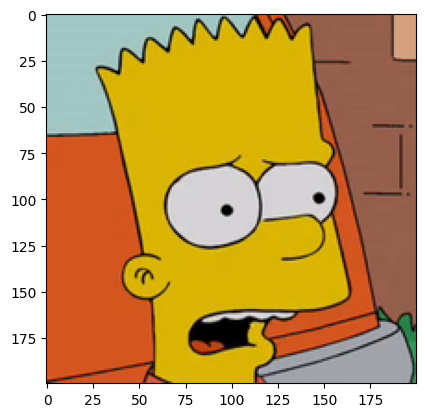

In [7]:
print(training_data.shape)
plt.imshow(training_data[0, :, :, :].permute(1, 2, 0))

In [8]:
training_images = training_data
print(training_data.mean())
training_images.shape
training_images = training_images*2 - 1

tensor(0.4777)


In [9]:
training_images.min()

tensor(-1.)

In [10]:
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

training_images = maxpool(training_images)
print(training_images.shape)

torch.Size([9877, 3, 100, 100])


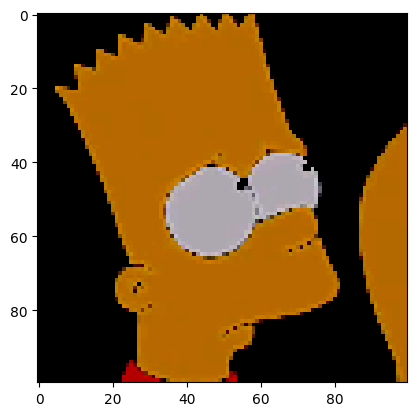

In [11]:
plt.imshow(training_images[1, :, :, :].permute(1, 2, 0))

In [38]:
data = DataLoader(training_images, batch_size=16, shuffle=True)


In [13]:
T = 1000
betas = torch.linspace(0.0001, 0.02, T)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0, dtype=torch.float64)

In [14]:
import math

def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

    return pe


embeddings = positionalencoding2d(T, 100, 100)

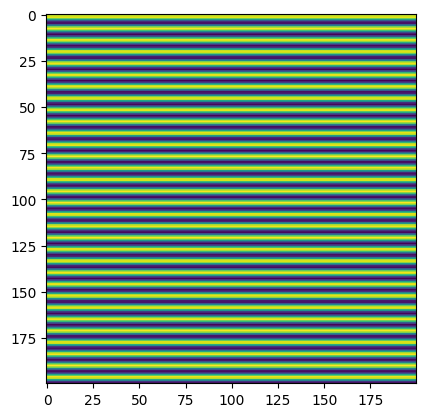

In [12]:
plt.imshow(embeddings[500, :, :])


In [56]:
import gc
gc.collect()

# Se stai usando più GPU, puoi farlo per una specifica
device = torch.device("cuda:0")  # Cambia a "cuda:1" se hai più GPU
with torch.cuda.device(device):
    torch.cuda.empty_cache()

# Opzionale: Resetta la memoria riservata
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()


del optimizer
del model

In [48]:
class DetailerDenoiser(nn.Module):
    def __init__(self, c=16):
        super().__init__()
        self.modules = [
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=5, padding='same'),
            nn.Tanh(),
        ]
        self.block = nn.Sequential(*self.modules)

    def forward(self, x):
        _in = x
        out = self.block(_in)
        return out + _in
        
class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Parametri:
          - channels: numero di canali in input (e output)
          - num_heads: numero di teste per l'attenzione (default 1)
        """
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads

        self.norm = nn.GroupNorm(num_groups=1, num_channels=channels)

        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)

        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        """
        x: [N, C, H, W]
        """
        B, C, H, W = x.shape

        h = self.norm(x)

        q = self.q(h).reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = self.k(h).reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = self.v(h).reshape(B, self.num_heads, C // self.num_heads, H * W)

        scale = (C // self.num_heads) ** -0.5
        attn = torch.einsum('bhdn,bhdm->bhnm', q, k) * scale
        attn = torch.softmax(attn, dim=-1)

        out = torch.einsum('bhnm,bhdm->bhdn', attn, v)
        out = out.reshape(B, C, H, W)

        out = self.proj_out(out)
        return x + out


In [57]:
class VarDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VarDoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)  # è come padding same in questo caso
        self.r1 = nn.ReLU(inplace=True)

        self.cmu = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)
        self.cvar = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)

        self.outconv = nn.Conv2d(1, out_channels, kernel_size=3, padding=1)
        self.r2 = nn.ReLU(inplace=True)

    def forward(self, x):
        _in = x
        x = self.r1(self.conv1(x))

        mean = self.cmu(x)
        logvar = self.cvar(x)

        epsilon = torch.randn_like(logvar)
        z = mean + torch.exp(logvar) * epsilon

        out = self.outconv(z)
        out = self.r2(out)

        return out, mean, logvar


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # è come padding same in questo caso
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels + skip_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)  # concatena lungo i canali
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, c=64):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Attention
        self.denoiser = DetailerDenoiser(c)
        self.att1 = SelfAttention(c * 2)
        self.att2 = SelfAttention(c * 4)
        self.attB = SelfAttention(c * 8)
        self.attB2 = SelfAttention(c * 8)

        self.attB5 = SelfAttention(c * 16)

        # Encoder
        self.inc = DoubleConv(n_channels, c)
        self.down1 = Down(c, c * 2)
        self.down2 = Down(c * 2, c * 4)
        self.down3 = Down(c * 4, c * 8)

        # Latent
        self.pool_latent = nn.AdaptiveAvgPool2d((16, 16))
        self.bottleneck = DoubleConv(c * 8, c * 16)

        # Decoder
        self.up1 = Up(c * 16, c * 8, c * 8, bilinear)
        self.up2 = Up(c * 8, c * 4, c * 4, bilinear)
        self.up3 = Up(c * 4, c * 2, c * 2, bilinear)
        self.up4 = Up(c * 2, c, c, bilinear)
        self.outc = OutConv(c, n_classes)

        # Time Step Encoder
        self.time_inc = DoubleConv(1, c)
        self.time_down1 = Down(c, c * 2)
        self.time_down2 = Down(c * 2, c * 4)
        self.time_down3 = Down(c * 4, c * 8)

    def forward(self, x, t):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.att1(x2)
        x3 = self.down2(x2)
        x3 = self.att2(x3)
        x4 = self.down3(x3)

        # Time Encode
        t1 = self.time_inc(t)
        t2 = self.time_down1(t1)
        t3 = self.time_down2(t2)
        t4 = self.time_down3(t3)

        # Latent
        x4_latent = self.pool_latent(x4)
        x4_latent = self.attB(x4_latent)
        # x4_latent = self.attB2(x4_latent)
        x5 = self.bottleneck(x4_latent)
        x5 = self.attB5(x5)

        # Decoder
        x = self.up1(x5, x4 + t4)
        x = self.up2(x, x3 + t3)
        x = self.up3(x, x2 + t2)
        x = self.up4(x, x1 + t1)
        x = self.denoiser(x)
        logits = torch.tanh(self.outc(x))
        return logits

model = UNet(3, 3, True, c=160)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model).cuda()

optimizer = Adam(model.parameters(), lr=0.0001)
model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
mean_losses = []

Let's use 2 GPUs!
270002883


In [17]:
def loss_function(x, x_hat, mean, log_var):
    #reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    me = nn.functional.l1_loss(x_hat, x, reduction='mean')
    KLD = 0 - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return KLD + me

criterion = loss_function
criterion = nn.MSELoss()


In [65]:
for epoch in range(3):
    total_loss = 0
    n_losses = len(data)
    mean_loss = 0
    for i, batch in enumerate(data):
        x = batch.to(device)
        t = torch.randint(0, T, (x.size(0),), device='cpu').long()
        alphas_bar_t = alphas_bar[t].view(-1, 1, 1, 1).to(device)
        noise = torch.randn_like(x) # epsilon nel paper
        noisy_images = (torch.sqrt(alphas_bar_t) * x + torch.sqrt(1 - alphas_bar_t) * noise).float()
        t_embs = embeddings[t]
        t_embs = t_embs.view(t_embs.shape[0], 1, t_embs.shape[1], t_embs.shape[2]).to(device)
        # y, mean, logvar = model(noisy_images, t_embs)
        y = model(noisy_images, t_embs)


        optimizer.zero_grad()
        # loss = criterion(noise, y, mean, logvar)
        loss = criterion(noise, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 100 == 0:
            print(f'step {i} - loss --- {loss.item()}')
    mean_loss = total_loss/n_losses
    print(epoch, mean_loss)
    mean_losses.append(mean_loss)
    #print(epoch, loss.item())

step 0 - loss --- 0.16511422395706177
step 100 - loss --- 0.16733190417289734
step 200 - loss --- 0.16748769581317902
step 300 - loss --- 0.17725680768489838
step 400 - loss --- 0.1605597287416458
step 500 - loss --- 0.1735021471977234
step 600 - loss --- 0.1723054051399231
0 0.17240718342243275
step 0 - loss --- 0.18735767900943756
step 100 - loss --- 0.15814326703548431
step 200 - loss --- 0.18320348858833313
step 300 - loss --- 0.16942419111728668
step 400 - loss --- 0.16183772683143616
step 500 - loss --- 0.16711817681789398
step 600 - loss --- 0.1711832880973816
1 0.17092752066052075
step 0 - loss --- 0.16074714064598083
step 100 - loss --- 0.17777864634990692
step 200 - loss --- 0.17530778050422668
step 300 - loss --- 0.17568720877170563
step 400 - loss --- 0.1728711724281311
step 500 - loss --- 0.16530132293701172
step 600 - loss --- 0.16732941567897797
2 0.1702306517264218


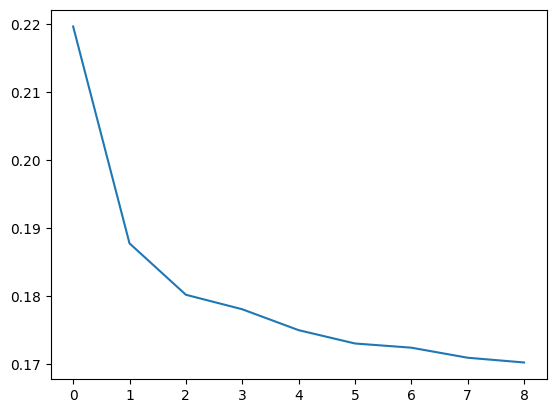

In [66]:
plt.plot(mean_losses)

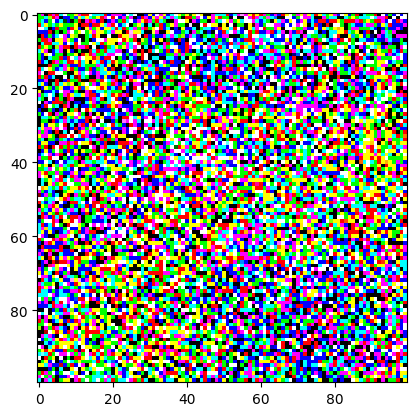

In [67]:
dim = 100
with torch.no_grad():
    # Start from pure noise:
    x = torch.randn((1, 3, dim, dim), device=device)
    
    for t in reversed(range(1, T)):
        # Get the time embedding for step t
        time_emb = embeddings[t].view(1, 1, dim, dim).to(device)
        
        # Predict the noise component for the current sample and timestep
        predicted_noise = model(x, time_emb)
        
        # Get current parameters from the noise schedule:
        alpha_t = alphas[t]            # scalar or tensor of shape [1] 
        alpha_bar_t = alphas_bar[t]      # cumulative product up to t
        beta_t = betas[t]                # variance for step t
        
        # Compute the reverse process mean
        x_mean = (1.0 / torch.sqrt(alpha_t)) * (
                  x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
                 )        
        #print(x.mean())
        if t > 1:
            # Add noise for stochasticity in reverse process:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = x_mean + sigma_t * noise
        else:
            x = x_mean  # final step, no noise added

with torch.no_grad():
    plt.imshow(x[0].cpu().numpy().transpose(1, 2, 0))
    plt.show()

In [100]:
print(x.mean())

tensor(-0.1814, device='cuda:0')


In [63]:
torch.save(model.state_dict(), "Sim270_6ep.pt")

In [156]:
model.load_state_dict(torch.load('/kaggle/working/Sim3.pt'))

<ipython-input-156-f151b483a04a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/Sim3.pt'))


<All keys matched successfully>